In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Challenge1/Andre

Mounted at /gdrive
/gdrive/.shortcut-targets-by-id/1hzamFV4kC27mUMEV9YGWnQmv2-k5TZvo/Challenge1/Andre


# Import things

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

#--------------------

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

#--------------------

import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

2.15.0


# Load And Inspect Data

In [ ]:
categories=np.load('training_dataset/categories.npy')
data=np.load('training_dataset/training_data.npy')
valid_periods=np.load('training_dataset/valid_periods.npy')

In [ ]:
print(categories.shape, categories.dtype)
print(data.shape, data.dtype)
print(valid_periods.shape, valid_periods.dtype)

(48000,) <U1
(48000, 2776) float64
(48000, 2) int64


In [ ]:
data = data.astype(np.float32)
valid_periods = valid_periods.astype(np.int32)
print(data.dtype)
print(valid_periods.dtype)

float32
int32


In [ ]:
int_cat = np.array([ord(char)-ord('A') for char in categories]) #ord(char) - ord('A'): This calculates the numerical representation of the characters in the categories array by subtracting the ASCII value of 'A' from the ASCII value of each character. This essentially maps 'A' to 0, 'B' to 1, and so on. The result is an array of integers where each element corresponds to one of the categories ('A' to 'F').
labels = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F'} #This dictionary is created to map the integer labels back to their corresponding categories. For example, labels[0] gives 'A', labels[1] gives 'B', and so on.
Size=categories.size

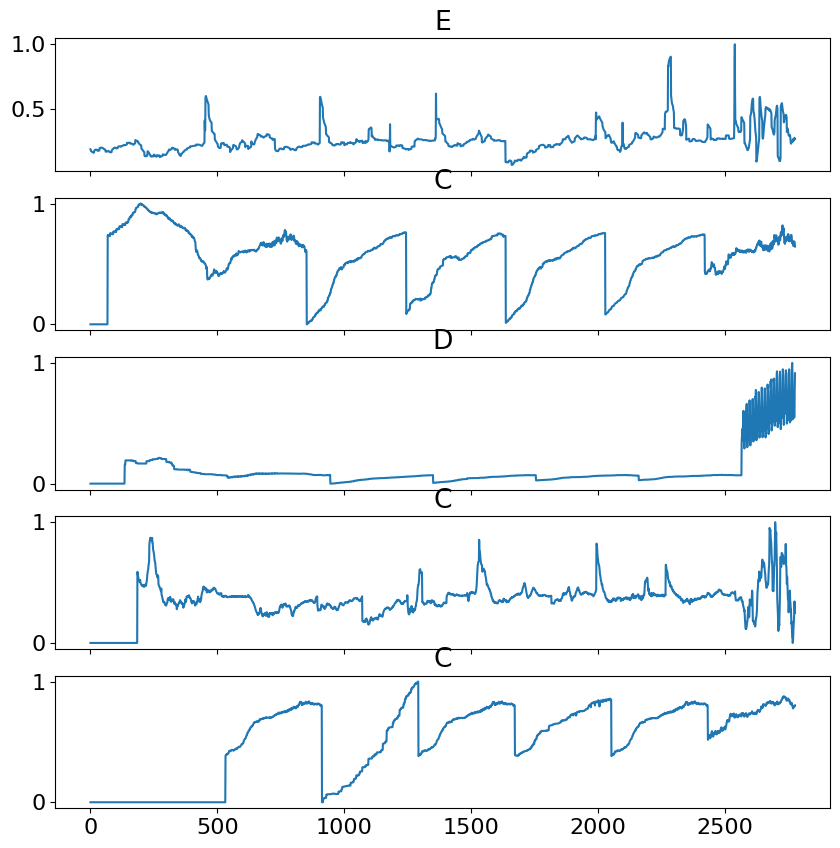

In [ ]:
# plot from the start of the non padded part to the end
indexes=valid_periods[:,0].argsort()
num=5
figs, axs = plt.subplots(num, 1, sharex=True, figsize=(10,10))
for i in range(num):
  axs[i].plot(data[indexes[i], :])
  axs[i].set_title(categories[indexes[i]])
plt.show()

# Categories Inspection

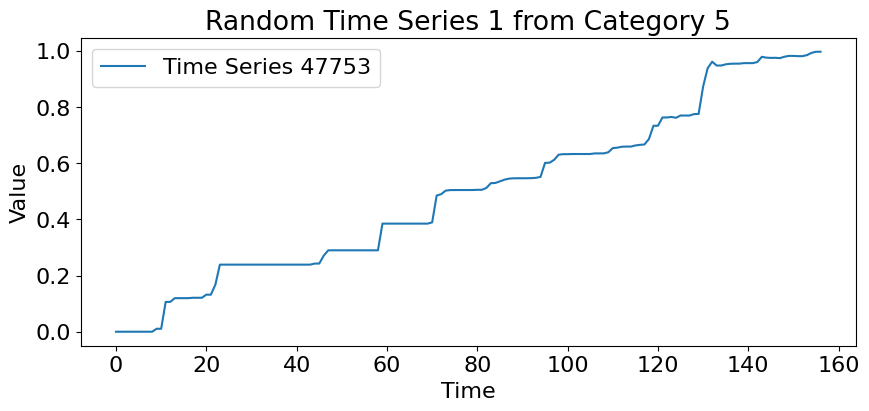

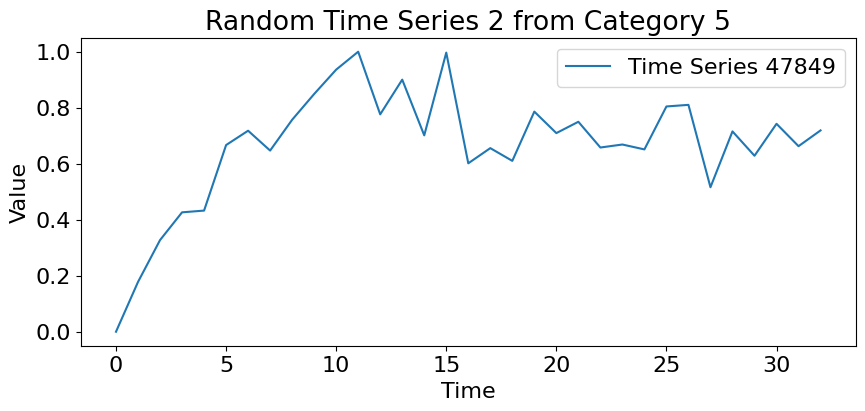

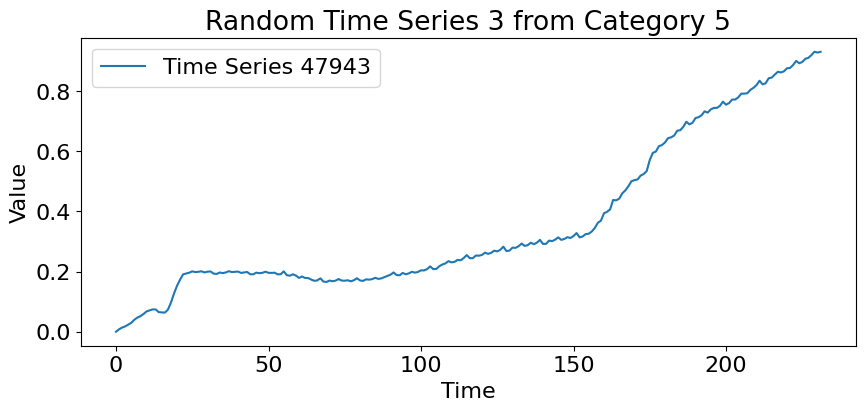

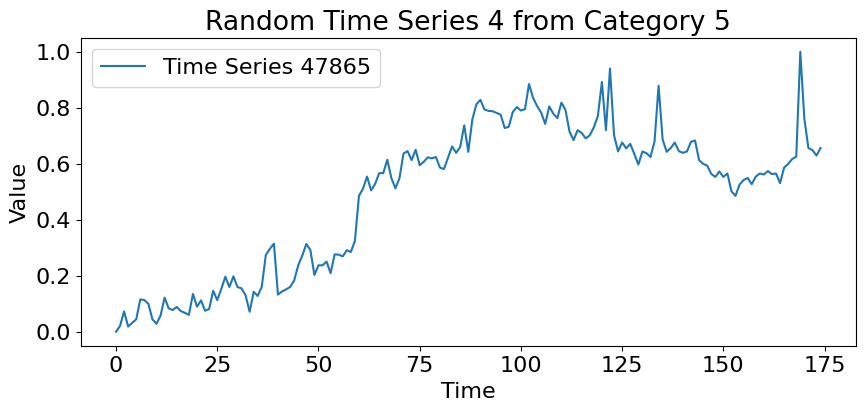

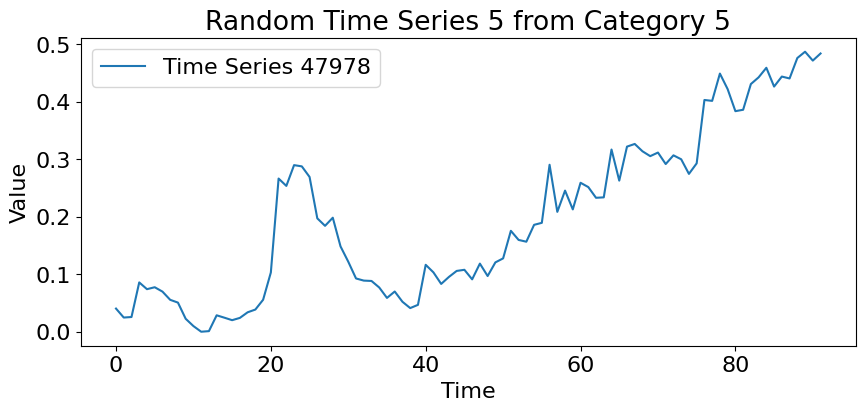

In [ ]:
selected_category = 5

# Get indices of time series in the selected category
indices_in_category = np.where(int_cat == selected_category)[0]

# Randomly select 5 time series from the chosen category
random_indices = np.random.choice(indices_in_category, 5, replace=False)

# Plot each of the 5 random time series in a separate plot
for i, idx in enumerate(random_indices):
    # Extract time series data and valid period for the current index
    time_series_data = data[idx, valid_periods[idx, 0]:valid_periods[idx, 1]]

    # Plot the time series
    plt.figure(figsize=(10, 4))
    plt.plot(time_series_data, label=f'Time Series {idx}')
    plt.title(f'Random Time Series {i + 1} from Category {selected_category}')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


# Data Split (train-test)

In [ ]:
ind_train, ind_test, cat_train, cat_test = train_test_split(  #ind_train and ind_test: These are the indices of the training and testing sets, respectively.
                                                              #cat_train and cat_test: These are the corresponding category labels for the training and testing sets.
    np.transpose(range(Size)),
    int_cat,
    test_size = 0.01,
    random_state = seed,
    stratify = int_cat
)
print(cat_test.size)
unique, count = np.unique(cat_train, return_counts=True)
print(count)
unique, count = np.unique(cat_test, return_counts=True)
print(count)

480
[ 5671 10877  9917  9916 10865   274]
[ 57 110 100 100 110   3]


In [ ]:
# Perform train-test split
ind_train, ind_test, cat_train, cat_test = train_test_split(
    np.arange(len(final_categories)),  # Use indices as input
    final_categories,
    test_size=0.01,
    random_state=seed,
    stratify=final_categories
)

# PreProcessing

AT THE END NO PREPROCESSED DATA WAS USED, THIS SECTION IS ONLY AS A REFERENCE FOR THE VARIOUS TRIES MADE

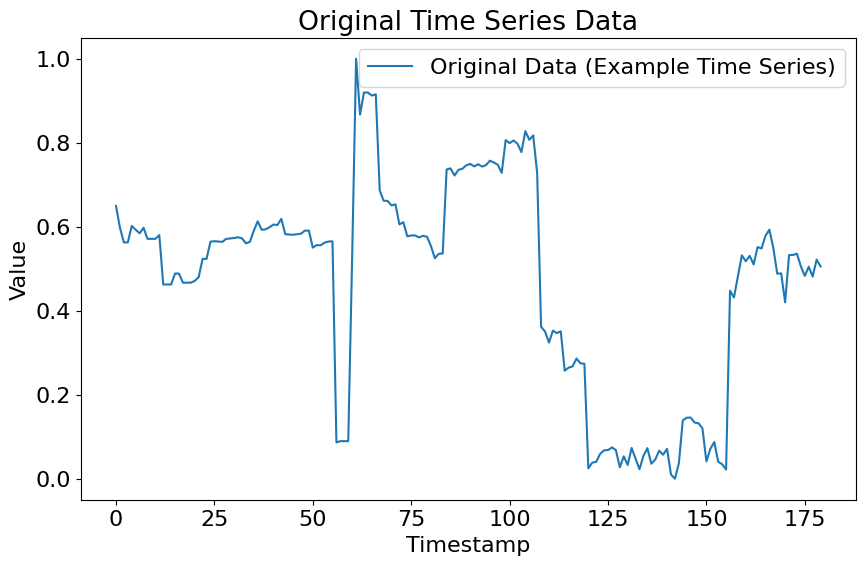

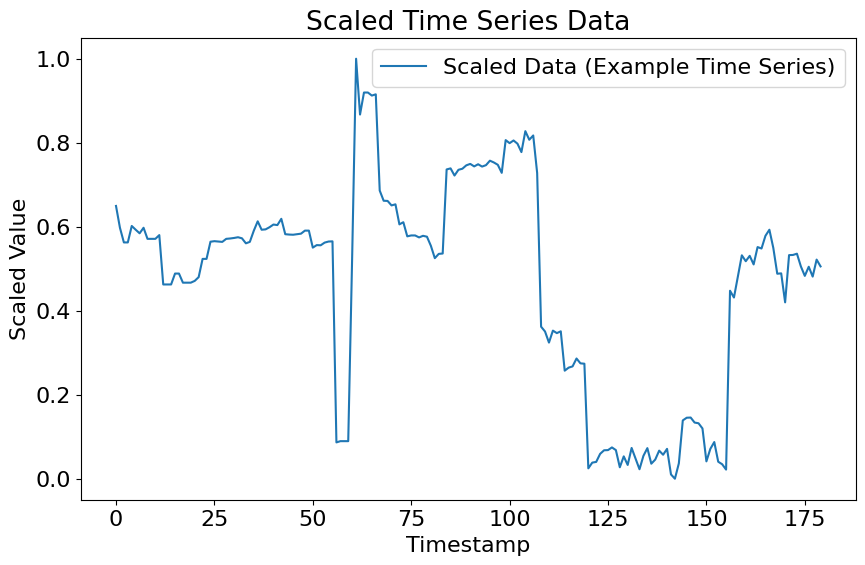

In [ ]:
# ----------------------------NORMALIZATION--------------------------------------
from sklearn.preprocessing import RobustScaler

datanorm = np.zeros((48000, 2776), np.float32)
for j in range(48000):
    data_2d = data[j].reshape(-1, 1)
    scaler = RobustScaler()
    normalized_data = scaler.fit_transform(data_2d)
    normalized_data_1d = normalized_data.flatten()
    datanorm[j] = normalized_data_1d


#-----------------PLOT THE DIFFERENCE-------------------------------------------
i=555

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(data[i,valid_periods[i][0]:], label='Original Data (Example Time Series)')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Original Time Series Data')

plt.legend()
plt.show()

# Plotting the scaled data
plt.figure(figsize=(10, 6))
plt.plot(datanorm[i,valid_periods[i][0]:], label='Scaled Data (Example Time Series)')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Scaled Value')
plt.title('Scaled Time Series Data')

plt.legend()
plt.show()
#-------------------------------------------------------------------------------


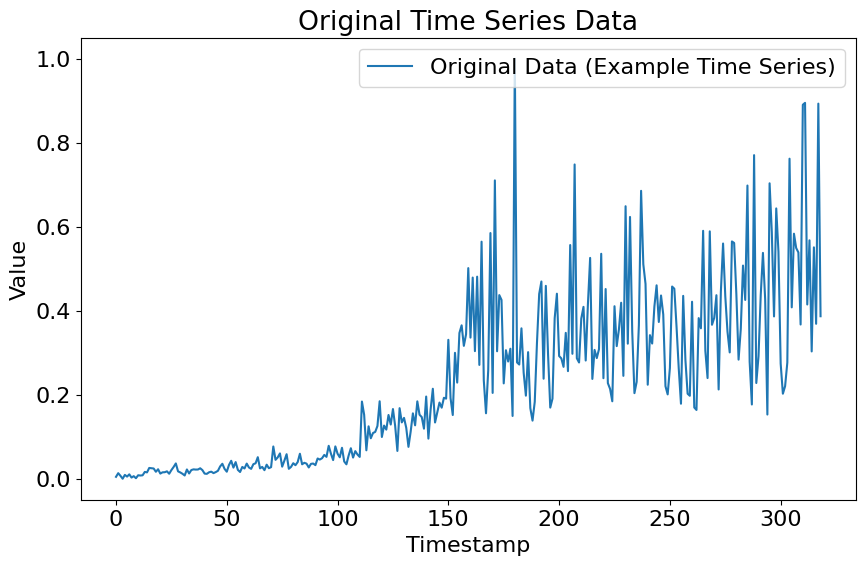

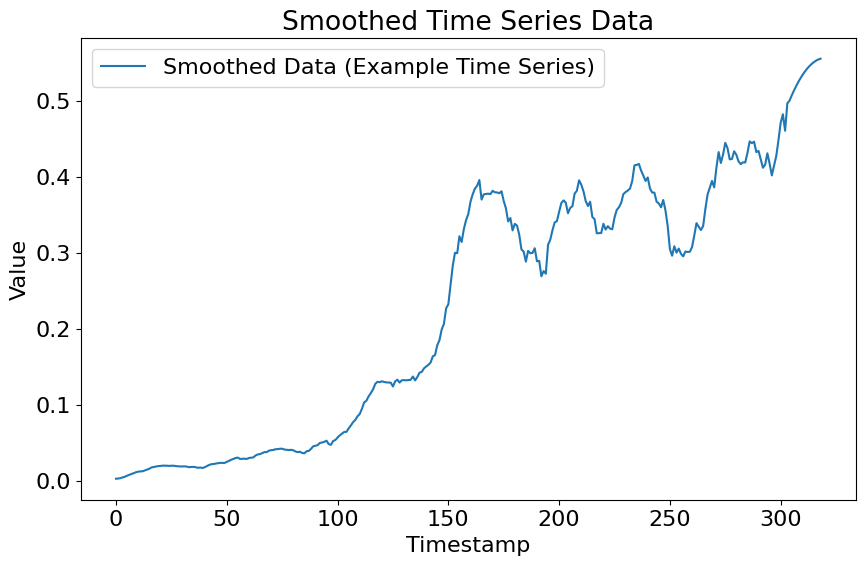

In [ ]:
# ----------------------------SMOOTHING--------------------------------------

#random_train = np.random.choice(ind_train, 500, replace=False)

'''ind_train_exp, test_exp, cat_train_exp, cat_test_exp = train_test_split(  #ind_train and ind_test: These are the indices of the training and testing sets, respectively.
                                                              #cat_train and cat_test: These are the corresponding category labels for the training and testing sets.
    ind_train,
    cat_train,
    test_size = 0.08,
    random_state = 69,
    stratify = cat_train
)

def objective(alpha, data):
    mse_total = 0.0
    #num_series = data.shape[0]

    for i in test_exp: #range(num_series):
        series = data[i, :]
        model = SimpleExpSmoothing(series)
        fit_model = model.fit(smoothing_level=alpha,optimized=False)
        predictions = fit_model.fittedvalues
        mse_total += mean_squared_error(series, predictions)

    return mse_total

# Perform optimization to find the optimal alpha for all time series
result = minimize(objective, x0=[0.5], args=(data,), bounds=[(0, 1)])
best_alpha = result.x[0]

print(f"Best alpha for all time series: {best_alpha}")

#best_alpha = 0.7166162962192525
best_alpha = 0.6
num_series = data.shape[0]
datasmooth = np.zeros_like(datadiff)

for i in range(num_series):
    series = datadiff[i, :]
    model = SimpleExpSmoothing(series)
    fit_model = model.fit(smoothing_level=best_alpha,optimized=False)
    datasmooth[i, :] = fit_model.fittedvalues



datasmooth = np.zeros_like(datadiff)
datasmooth[:, 0] = datadiff[:, 0]

# Perform exponential smoothing
for i in range(1, datadiff.shape[1]):
    datasmooth[:, i] = best_alpha * datadiff[:, i] + (1 - best_alpha) * datasmooth[:, i - 1]'''

from scipy.signal import savgol_filter

# Assuming your original data is named 'data'
# Assuming ind_train contains the indices for training data

# Extract the training data based on ind_train

# Choose a window size (e.g., 5) and polynomial order (e.g., 2)
window_size = 10
poly_order = 2

# Perform Savitzky-Golay smoothing on the training data
datasmooth = np.apply_along_axis(lambda x: savgol_filter(x, window_size, poly_order), axis=1, arr=data)


#-----------------PLOT THE DIFFERENCE-------------------------------------------
i=6900

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(data[i,valid_periods[i][0]:], label='Original Data (Example Time Series)')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Original Time Series Data')

plt.legend()
plt.show()

# Plotting the scaled data
plt.figure(figsize=(10, 6))
plt.plot(datasmooth[i,valid_periods[i][0]:], label='Smoothed Data (Example Time Series)')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Smoothed Time Series Data')

plt.legend()
plt.show()
#-------------------------------------------------------------------------------


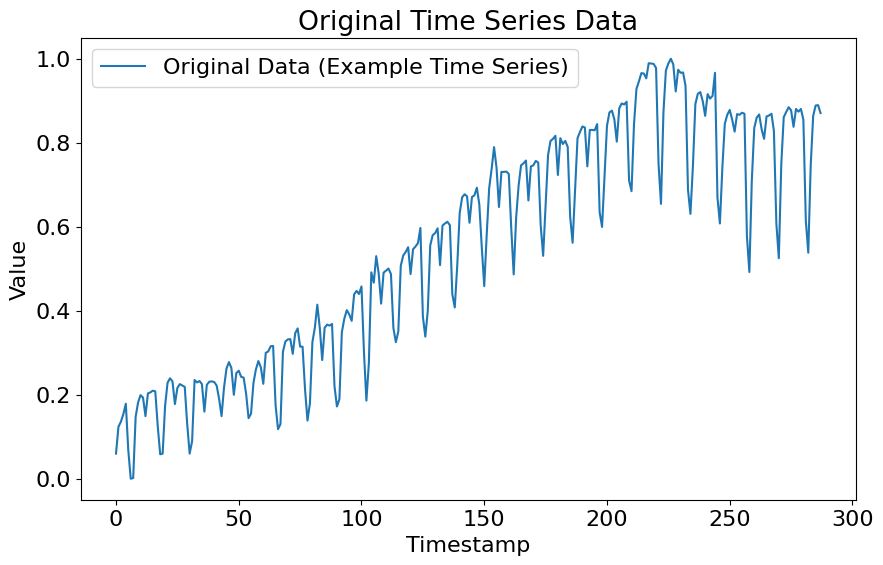

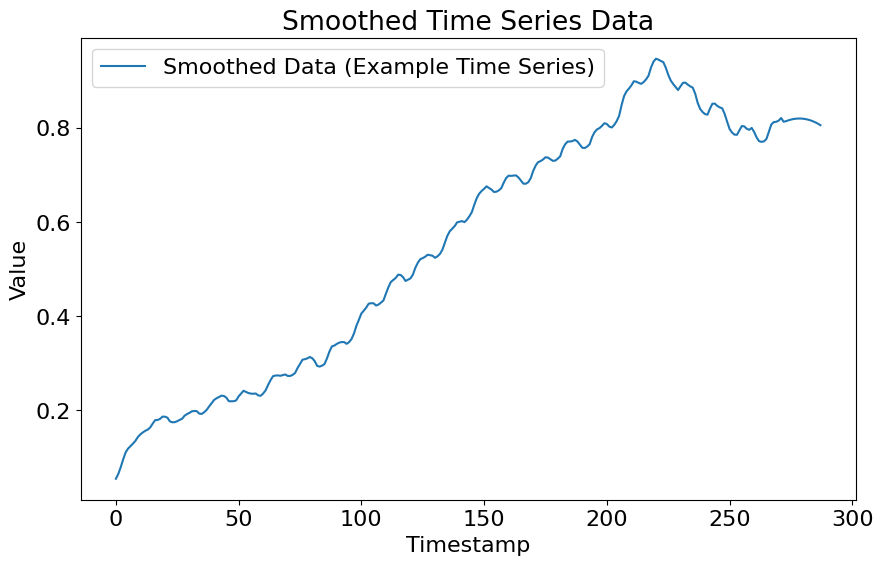

In [ ]:
#-----------------PLOT THE DIFFERENCE-------------------------------------------
i=690

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(datanorm[i,valid_periods[i][0]:], label='Original Data (Example Time Series)')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Original Time Series Data')

plt.legend()
plt.show()

# Plotting the scaled data
plt.figure(figsize=(10, 6))
plt.plot(datasmooth[i,valid_periods[i][0]:], label='Smoothed Data (Example Time Series)')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Smoothed Time Series Data')

plt.legend()
plt.show()

# Data Split (train - val)

In [ ]:
ind_train_split, ind_val_split, cat_train_split, cat_val_split = train_test_split(
    ind_train,
    cat_train,
    test_size=0.1,  # Adjust the validation set size as needed
    random_state=seed,
    stratify=cat_train  # Stratified sampling based on category labels
)

# Build Sequences

In [ ]:
window = 80
stride = 40
telescope = 9

In [ ]:
def build_sequences(ind, data=data, periods=valid_periods, cat=int_cat, window=120, stride=40, telescope=18):

    # Sanity check to avoid runtime errors
    assert window % stride == 0

    dataset = []
    labels = []
    indexes=[]

    WT=window+telescope

    for jj in ind:
      temp_X = data[jj,periods[jj,0]:periods[jj,1]]
      length = len(temp_X)
      padding_len=0
      if(length < WT):
        padding_len = WT-length
        padding= np.zeros((padding_len), dtype='float32')
        temp_X = np.concatenate((padding,temp_X))
        dataset.append(temp_X[:window])
        labels.append(temp_X[window:WT])
        indexes.append(cat[jj])

      elif (length-WT)%40 !=0 :
        padding_len = 40 - (length-WT)%40
        padding= np.zeros((padding_len), dtype='float32')
        temp_X = np.concatenate((padding,temp_X))

        for idx in np.arange(0,len(temp_X)-window-telescope+1,stride):
          dataset.append(temp_X[idx:idx+window])
          labels.append(temp_X[idx+window:idx+WT])
          indexes.append(cat[jj])

    dataset = np.array(dataset)
    labels = np.array(labels)
    indexes=np.array(indexes)
    return dataset, labels, indexes

In [ ]:
X_train, y_train, cat_train = build_sequences(ind_train_split)
X_val, y_val, cat_val = build_sequences(ind_val_split)
#X_test, y_test, cat_test = build_sequences(ind_test, final_data)

X_train= np.expand_dims(X_train, axis=2)
X_val= np.expand_dims(X_val, axis=2)
#X_test= np.expand_dims(X_test, axis=2)
y_train= np.expand_dims(y_train, axis=2)
y_val = np.expand_dims(y_val, axis=2)
#y_test= np.expand_dims(y_test, axis=2)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, # X_test.shape, y_test.shape, X_val.shape, y_val.shape

((171479, 120, 1), (171479, 18, 1), (19052, 120, 1), (19052, 18, 1))

# Model

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

print(input_shape)
print(output_shape)

(120, 1)
(18, 1)


In [ ]:
def build_CONV_LSTM_model(input_shape, output_shape, heads=10, time2vec_embedding_dim=64):
    assert input_shape[0] >= output_shape[0]

    # Input layer with additional time-related features
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Time2Vec layer to embed time-related features
    time2vec_embedding = tfkl.Embedding(input_dim=input_shape[0], output_dim=time2vec_embedding_dim, mask_zero=True)(input_layer[:,:,0])
    time2vec_embedding = tf.reduce_mean(time2vec_embedding, axis=1)  # Average pooling over time dimension

    # Repeat the time2vec_embedding along the time dimension to match the sequence length
    time2vec_embedding = tfkl.RepeatVector(input_shape[0])(time2vec_embedding)

    # Concatenate the time2vec_embedding with the input data
    x = tfkl.Concatenate(axis=-1)([input_layer, time2vec_embedding])

    # Continue with the rest of your model architecture
    x = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru'), name='bidirectional_lstm')(x)
    x = tfkl.Bidirectional(tfkl.GRU(64, return_sequences=True, name='gru1'), name='bidirectional_lstm1')(x)

    x = tfkl.BatchNormalization()(x)

    # Apply multihead attention
    x = tfkl.MultiHeadAttention(num_heads=heads, key_dim=128)(x, x)

    x = tfkl.Conv1D(128, 5, padding='same', activation='leaky_relu', name='conv1')(x)
    x = tfkl.SpatialDropout1D(0.3)(x)

    x = tfkl.Conv1D(64, 5, padding='same', activation='leaky_relu', name='conv2')(x)
    x = tfkl.SpatialDropout1D(0.3)(x)

    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)

    # Calculate the size to crop from the output to match the output shape
    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam())

    return model


In [ ]:
model = build_CONV_LSTM_model(input_shape, output_shape)
model.summary()
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

Model: "CONV_LSTM_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 120, 1)]             0         []                            
                                                                                                  
 bidirectional_lstm (Bidire  (None, 120, 128)             25728     ['input_layer[0][0]']         
 ctional)                                                                                         
                                                                                                  
 bidirectional_lstm1 (Bidir  (None, 120, 128)             74496     ['bidirectional_lstm[0][0]']  
 ectional)                                                                                        
                                                                                    

In [ ]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    #validation_split = .1,
    validation_data=(X_val,y_val),
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True, min_delta=0.0001),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=8, factor=0.1, min_lr=1e-5, min_delta=0.0001)
    ]
).history

Epoch 1/200
2680/2680 [==============================] - 122s 42ms/step - loss: 0.0226 - val_loss: 0.0173 - lr: 0.0010
Epoch 2/200
2680/2680 [==============================] - 113s 42ms/step - loss: 0.0167 - val_loss: 0.0145 - lr: 0.0010
Epoch 3/200
2680/2680 [==============================] - 112s 42ms/step - loss: 0.0155 - val_loss: 0.0139 - lr: 0.0010
Epoch 4/200
2680/2680 [==============================] - 116s 43ms/step - loss: 0.0151 - val_loss: 0.0133 - lr: 0.0010
Epoch 5/200
2680/2680 [==============================] - 114s 42ms/step - loss: 0.0147 - val_loss: 0.0136 - lr: 0.0010
Epoch 6/200
2680/2680 [==============================] - 112s 42ms/step - loss: 0.0143 - val_loss: 0.0134 - lr: 0.0010
Epoch 7/200
2680/2680 [==============================] - 111s 41ms/step - loss: 0.0139 - val_loss: 0.0126 - lr: 0.0010
Epoch 8/200
2680/2680 [==============================] - 111s 42ms/step - loss: 0.0136 - val_loss: 0.0127 - lr: 0.0010
Epoch 9/200
2680/2680 [=========================

# Assert Performance

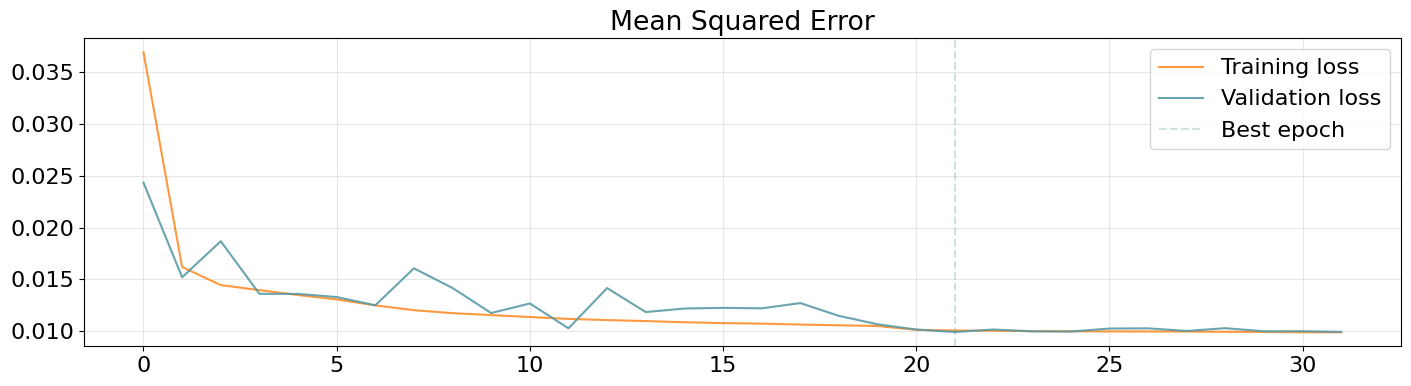

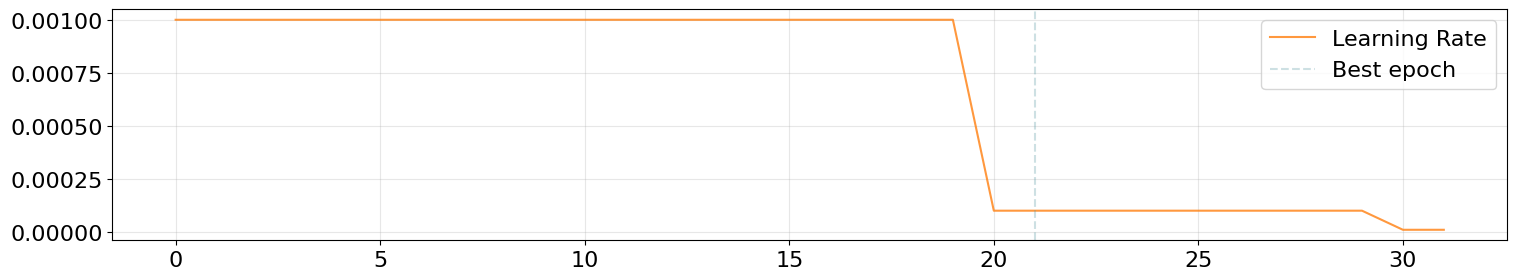

In [ ]:
# @title
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [ ]:
model.save('Fupsalmpling')
del model

In [ ]:
model = tfk.models.load_model('embeddingfirstry')

# Predict the test set using the model
telescope = 18
window=120

selected_rows = []
for i in ind_test:
    start = valid_periods[i][0]
    end = valid_periods[i][1]

    # Check if the difference is greater than 130
    if end-start >= window+telescope:
        selected_rows.append(i)

# Extract the selected rows
test_data = data[selected_rows]

# Separate the last 9 values into the 'actual' vector
y_ttest = test_data[:, -telescope:]
X_ttest = test_data[:, -(window+telescope):-telescope]

predictions = model.predict(X_ttest, verbose = 0)

# Print the shape of the reg_predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_ttest.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_ttest.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

Predictions shape: (302, 18, 1)
Mean Squared Error: 0.008206995204091072
Mean Absolute Error: 0.060689784586429596


In [ ]:
# Predict the test set using the model
telescope = 18
window=120
scaler = MinMaxScaler()

selected_rows = []
cat_for=[]
for i in ind_test:
    start = valid_periods[i][0]
    end = valid_periods[i][1]

    # Check if the difference is greater than 130
    if end-start >= 130:
        selected_rows.append(i)
        cat_for.append(int_cat[i])

# Extract the selected rows
test_data = data[selected_rows]
test_cat = int_cat[selected_rows]

# Separate the last 9 values into the 'actual' vector
y_ttest = test_data[:, -telescope:]
X_test = test_data[:, -(window+telescope):-telescope]

predictions = model.predict(X_test, verbose = 0)
predictions = predictions[:,:,0]

# Print the shape of the reg_predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_ttest.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_ttest.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

for c in range(6):
  test=X_test[[index for index, value in enumerate(cat_for) if value == c]]
  predictions = model.predict(test, verbose=0)
  print(f"Predictions shape: {predictions.shape}")
  mean_squared_error = tfk.metrics.mean_squared_error(y_ttest[[index for index, value in enumerate(cat_for) if value == c]].flatten(), predictions.flatten()).numpy()
  print(f"Mean Squared Error:{labels[c]}: {mean_squared_error}")
